# Mel Frequency Cepstral Coefficients Without Magic

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy.signal as sig
import scipy.fftpack as sp_fft
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt

from ipywidgets import interact, IntSlider
from matplotlib.offsetbox import AnchoredText
from IPython.display import display, Audio

from dssplib import stft, istft, mel_filterbank, mfcc, inv_mfcc
from dssplib import plot_time_domain_signal, plot_time_domain_and_spectrogram
from dssplib import plot_stft, plot_mel_spectogram

plt.rcParams['figure.figsize'] = (15.0, 4.0)

![MFCC pipeline](http://www.rroij.com/articles-images/IJIRCCE-310-g003.gif)

## Useful constants

In [3]:
fft_length = 1024
sample_rate = 16000
freq = np.arange(fft_length)/fft_length*sample_rate

## Load Speech Input Signal

In [4]:
sample_rate, x_in = wav.read("fg_nt_upb_16k.wav")
x_in = x_in.astype(np.float)/np.abs(x_in).max()

<ipython-input-4-452f21cdcb6d>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_in = x_in.astype(np.float)/np.abs(x_in).max()


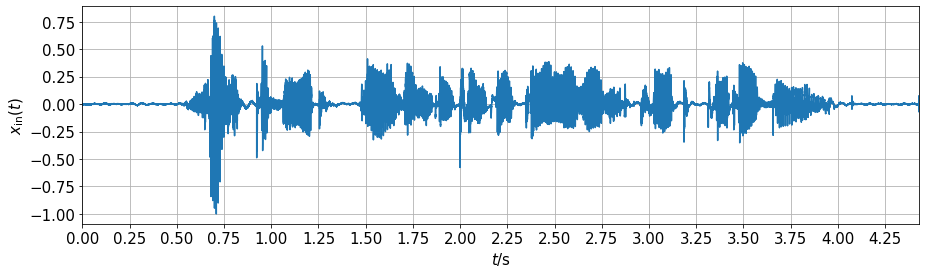

In [21]:
plot_time_domain_signal(x_in, sample_rate=sample_rate, ylabel=r'$x_\mathrm{in}(t)$')
plt.savefig('raw_wave.pdf')

## Mel filterbank

The mel filterbank consists of a predefined number of asymmetric triangular filters which span the range from the previous center frequency over the current one (where they reach their maximum) towards the next center frequency.

\begin{align}
    F_{\mathrm{mel}, j}(k) = \begin{cases}
        \frac{k - k_{c, j-1}}{k_{c,j} - k_{c,j-1}} : & k_{c,j-1} \leq k \leq k_{c, j} \\
        \frac{k_{c, j+1} - k}{k_{c,j+1} - k_{c,j}} : & k_{c,j} \leq k \leq k_{c, j+1} \\
        0 : &\mathrm{else.}
   \end{cases}
\end{align}

**The center frequencies are constructed so that they have an equal spacing when they are converted to the mel scale**. This causes the width of the triangles to increase towards higher frequencies.
    
The application of the filter bank is discussed below.

To understand it better, you can e.g. use `nfilters = 10`. The default for mfccs is 26, but when the logmel features are directly used as input for a neural network, a value of `nfilters = 128` is not uncommon.

In [6]:
nfilters = 26
filter_banks, nfilters, f_center = mel_filterbank(nfilters=nfilters)

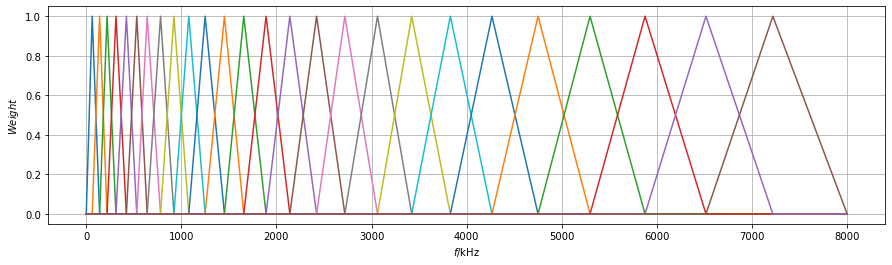

In [19]:
for i, fbank in enumerate(filter_banks):
    plt.plot(freq[:fft_length//2+1], fbank)
    plt.xlabel(r'$f / \mathrm{kHz}$')
    plt.ylabel(r'$Weight$')
plt.grid(True)
plt.savefig('mel_filterbank.pdf')

## Calculate the STFT
As described earlier, the STFT is calculated with a windowed FFT:

\begin{align}
    X(k, m) = \mathrm{FFT}_N\left\{ x(n - m \cdot B) \cdot w_{N_w}(n) \right\}
\end{align}

Here, frames of the same length as the window are cut out of the signal, multiplied with the window function and transformed ($k$ is the frequency bin index). It is often of advantage to have the window length $N_w$ differing from the FFT length $N$. Furthermore, the frame shift $B$ can be a fracton of the actual window length.

[[-0.62676016+0.j         -0.74738029+0.j         -0.93428263+0.j
  ...  0.8877777 +0.j          0.5540763 +0.j
  -0.31955752+0.j        ]
 [ 0.04420657+0.51465624j  0.0550982 +0.58914335j  0.10176089+0.77991155j
  ... -0.01880303-0.76283369j  0.30543689-0.53892733j
   0.42899532+0.31640172j]
 [ 0.29526524-0.08850792j  0.24706272-0.0357431j   0.44980691-0.16651346j
  ... -0.44550296+0.03367966j -0.4902723 -0.36652216j
   0.29616432-0.5815935j ]
 ...
 [-0.1215756 +0.15772551j  0.03994543-0.03587287j -0.16256407+0.18565845j
  ...  0.02802761-0.08768417j -0.21173616-0.41039305j
  -0.42954276+0.24189017j]
 [ 0.29526524+0.08850792j  0.24706272+0.0357431j   0.44980691+0.16651346j
  ... -0.44550296-0.03367966j -0.4902723 +0.36652216j
   0.29616432+0.5815935j ]
 [ 0.04420657-0.51465624j  0.0550982 -0.58914335j  0.10176089-0.77991155j
  ... -0.01880303+0.76283369j  0.30543689+0.53892733j
   0.42899532-0.31640172j]]


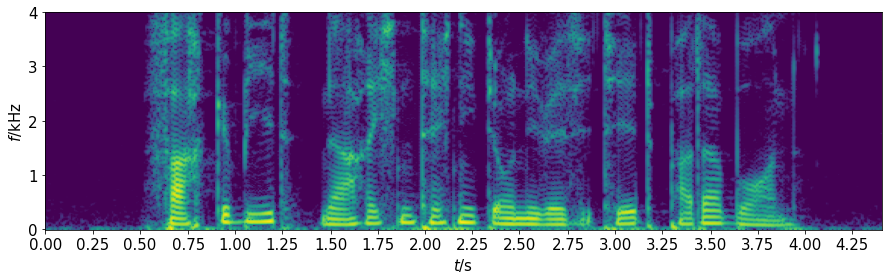

In [23]:
X = stft(x_in, window='hamming')
plot_stft(X, sample_rate=16000, floor_val=-55)
#plt.savefig('stft.pdf')
print(X)

## Apply the mel filterbank
In contrast to an actual filter transfer function, the mel filters are applied by a pointwise multiplication and a summation along the frequency axis afterwards:

\begin{align}
    X_\mathrm{mel}(j, m) = \sum_{k=0}^{N/2} F_\mathrm{mel, j}(k) \cdot P(k, m)
\end{align}

Here, $P(k, m)$ is the periodogram (the power spectral density estimate) calculated from the STFT:

\begin{align}
    P(k, m) = \frac{\left| X(k, m) \right|^2}{N}
\end{align}

If the mel filterbank is stored as a matrix, the transformation can be done with a matrix multiplication.

In [9]:
X_mel = filter_banks @ np.abs(X[:fft_length//2+1])**2/fft_length
print(f'X_mel.shape : {X_mel.shape}')

X_mel.shape : (26, 551)


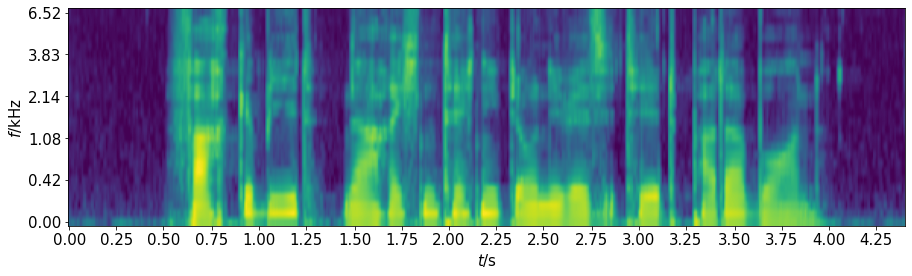

In [25]:
plot_mel_spectogram(X_mel, f_center, floor_val=-120)
#plt.savefig('mel_spectrogram.pdf')

It can be seen in the figure that the low frequency components are streched while the higher frequencies are compressed. This corresponds exactly to the spacing of the center frequencies which follows the mel scale.
Furthermore, some smoothing is already performed by the binning operation.

# Getting the Cepstral Coefficients

The cepstrum transformation is defined as

\begin{align}
    X_\mathrm{cep}(q, m) = \mathrm{DCT}_{N_\mathrm{Filters}} \left\{ X_\mathrm {mel}(j, m) \right\}
\end{align}

The transformation is carried out with respect to the mel index $j$.    
The logarithm is very important: Without it, one would only get back a time domain representation for every frame. Due to the logarithm however:
- A compression of the amplitudes is carried out. Thus, smaller amplitudes become more important, while differences between larger amplitudes are suppressed. This corresponds to the auditory perception.
- Products are transformed into sums: $\log( H \cdot X) = \log(H) + \log(X)$. **This allows for separation of fast-changing parts, i.e. the excitation,  and slow-changing parts, i.e. the vocal tract filter**.

The second property can be exploited by performing cepstral smoothing. See below for more.

X_cep: (26, 551)


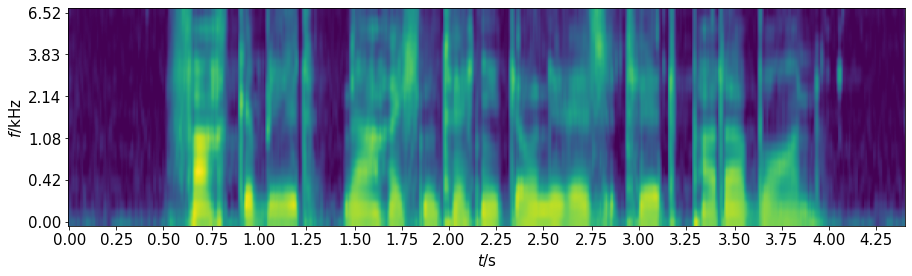

In [27]:
X_log_mel = np.log(X_mel)
X_cep = sp_fft.dct(X_log_mel, n=nfilters, type=2, norm='ortho', axis=0)
print(f'X_cep: {X_cep.shape}')
X_cep = X_cep[:13] # The cepstral smoothing part
X_log_mel_smooth = sp_fft.idct(X_cep, n=nfilters, type=2, norm='ortho', axis=0)

plot_mel_spectogram(X_log_mel_smooth, f_center, floor_val=-120, scale='lin')
#plt.savefig('mfcc.pdf')

**The Variable `X_cep` contains the so-called *static* MFCCs now. To get rid of the fine structure caused by the excitation signal, the upper cepstral coefficients are discarded**. Often, the first coefficient is discarded as well.
After this step, a cepstral mean normalization is often performed, which calculates the mean of every coefficient over all time frames and subtracts it from the coefficients. This removes time-invariant transfer functions and is thus able to perform an environment equalization.
Additionally, delta and delta-delta coefficients are often calculated, which correspond to the first and second derivative along the time axis. However, these steps are not discussed in detail here.


Since a plot of cepstral coefficients is not very helpful, a back-transformation into the log-mel domain is done with the help of the inverse dct. The most obvious effect visible in the mel-spectrogram is the result of the cepstral smoothing. It can be seen that the fine details caused by the pitch frequency and the harmonics are removed.

# Inverse Transformation
To return to the STFT domain, the following steps must be taken
1. The inverse dct must be taken. This is already done above to plot the result of cepstral smoothing in the log-mel domain.
2. The logarithm has to be undone and thus the exponential function is applied element-wise.
3. The mel filterbank effect has to be inverted. This is not possible in an exact fashion, since the filterbank matrix is not quadratic. Instead, $\mathrm{rank}\left(\mathbf{F}_\mathrm{mel}\right) = N_\mathrm{filters} < N/2$. However, a [pseudo inverse](https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_pseudoinverse), can be found in a least-squares sense. This is done by the numpy function [`np.linalg.pinv`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.pinv.html). This results in a reconstructred periodogram.
4. The absolute spectrum has to be calculated from the periodogram.
5. The phase has to be recovered. In application scenarios, this is often not possible. However, this last step is only necessary if a time-domain signal is needed since one would work with power spectra anyways.

In [12]:
X_stft_rec_abs = fft_length*np.sqrt(np.abs(np.linalg.pinv(filter_banks) @ np.exp(X_log_mel_smooth)))
X_stft_rec = X_stft_rec_abs * np.exp(1j*np.angle(X[:fft_length//2 +1]))

#### Exploit hermitian symmetry to get the full STFT

In [13]:
X_stft_rec_full = np.concatenate([X_stft_rec, X_stft_rec[fft_length//2:1:-1]], axis=0)

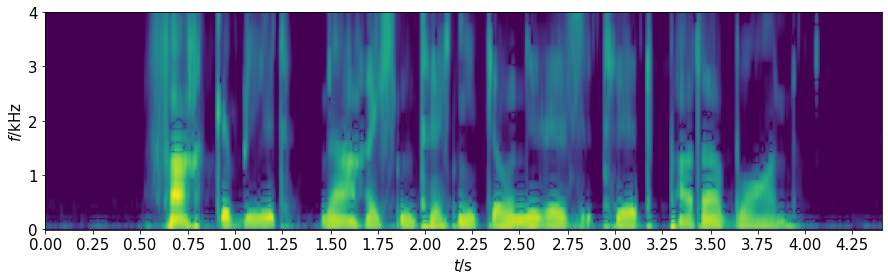

In [14]:
plot_stft(X_stft_rec_full, floor_val=-55)

The result in the STFT domain is an agressively smoothed spectrum.

# How does the smoothing effect sound? (smoothing = non-causal window)

To make the result hearable, the STFT needs to be inverted as well.
This can be done by performing IFFTs of every frame, multiplying them with synthesis window and performing an overlapped addition of the frames. Details of this can be found in the [Springer Handbook of Speech Processing on Page 231](https://books.google.de/books?id=Slg10ekZBkAC&dq=handbook%20of%20speech%20processing%20stft&pg=PA231).
Note that the resulting spectrogram looks different to the reconstruction above since it is created from the time domain signal.

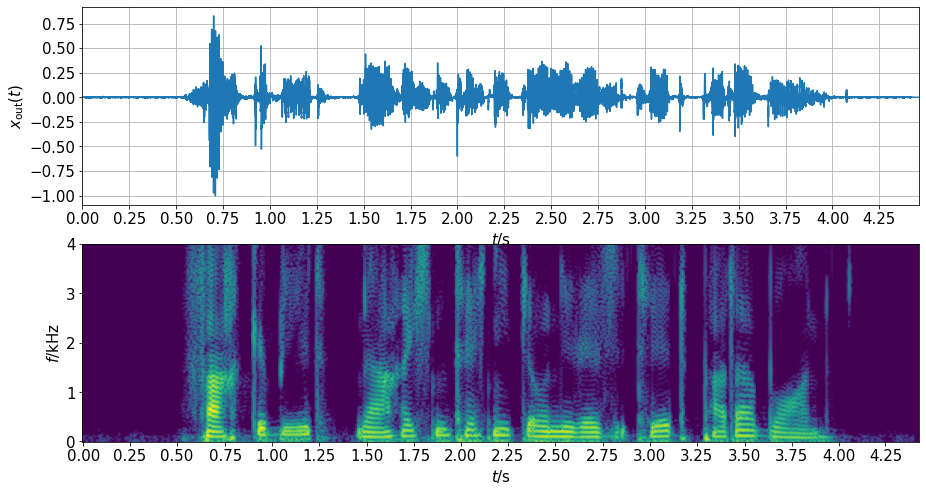

In [15]:
x_out = istft(X_stft_rec, window='hamming')
x_out /= np.abs(x_out).max()

plot_time_domain_and_spectrogram(x_out, sample_rate=sample_rate, ylabel=r'$x_\mathrm{out}(t)$',
                                 floor_val=-50)

In effect, the speech sound more like noise, since the voiced parts are transformed into voiceless parts as well.
It should be noted, however, that another STFT of the output time-domain signal reintrodices artifacts caused by **Ghosting** and **Blurring**, thus, a lot of the smoothing effect is destroyed.

# And how does the Difference sound?

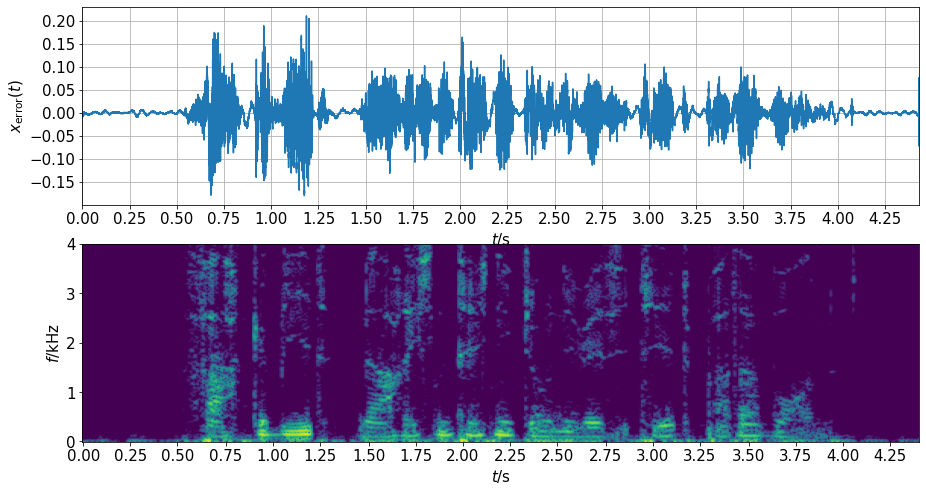

In [16]:
x_error = x_in - x_out[:len(x_in)]

plot_time_domain_and_spectrogram(x_error, sample_rate=sample_rate, ylabel=r'$x_\mathrm{error}(t)$')

It can be seen that the error signal contains mostly the fine-grained parts of the input signal. In effect, it sounds like it was spoken through a resonating metal tube, since the voiced parts dominate.

# Sticking it all together
Play around with the following function, which shows the complete calculation of MFCCs and reconstruction into time domain:

In [17]:
@interact(nfilters=IntSlider(min=1, max=256, step=1, value=26), 
          ncep=IntSlider(min=1, max=256, step=1, value=13))
def play_mfcc(nfilters, ncep):
    window_length, frame_shift = 400, 160 # standard mfccs
    X_stft = stft(x_in, window='hamming', window_length=window_length,
                  frame_shift=frame_shift)
    
    X_mfcc, X_phase, f_center, filter_banks = mfcc(x_in, ncep=ncep, fft_length=fft_length,
            window_length=window_length, frame_shift=frame_shift, nfilters=nfilters, window='hamming')
    x_out, X_out_stft = inv_mfcc(X_mfcc, X_phase, fft_length=fft_length, window_length=window_length,
            frame_shift=frame_shift, filter_banks=filter_banks, window='hamming')

    x_out /= np.abs(x_out).max()
    
    display(Audio(x_out, rate=16000, autoplay=False))
    plt.figure(figsize=(30, 15))
    plt.subplot(2, 1, 1);
    plot_stft(X_stft, floor_val=-60, frame_shift=frame_shift)
    plt.subplot(2, 1, 2);
    X_rec = np.concatenate([X_out_stft, X_out_stft[fft_length//2:1:-1].conj()], axis=0)
    plot_stft(X_rec, floor_val=-60, frame_shift=frame_shift)
    plt.show()

interactive(children=(IntSlider(value=26, description='nfilters', max=256, min=1), IntSlider(value=13, descrip…

The plots show the input spectrum and the spectrum reconstructed from the MFCCs. By changing the slider values, the number of mel filters and the cutoff number of cepstral coefficients can be varied. Try out differnt combinations and hear how it sounds. For example, Try to reduce the number of cepstral coefficients to 1. Standard MFCCs use 26 mel filters and 13 cepstral coefficients.